In [1]:
import pandas as pd
import numpy as np
import requests
import folium
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, mapping
from shapely import GeometryCollection, MultiPolygon
from shapely.ops import unary_union
import json

In [2]:
PICKLE_PATH = "../../pickled/pickled-chickens.pickle"
FSIS_DATA = "../../data/fsis-processors-with-location.csv"

In [3]:
# constants for coordinate projections
ALBERS_EQUAL_AREA = "EPSG:9822"
WGS84 = "EPSG:4326"

#### Load Chickens DF

In [4]:
df_large_chickens = pd.read_pickle(PICKLE_PATH)

In [5]:
df_large_chickens = gpd.GeoDataFrame(df_large_chickens).set_geometry("Isochrone")
df_large_chickens.head()

,Unnamed: 0,EstNumber,EstID,Parent Corporation,Establishment Name,State,Size,Animals Processed,Processed\nVolume\nCategory,Slaughter\nVolume\nCategory,Full Address,latitude,longitude,Isochrone
71,71,P1317 + V1317,4495,Cargill,Wayne Farms LLC,AL,Large,Chicken,5.0,5.0,"700 McDonald Avenue, Albertville, AL 35950",34.260726,-86.203222,"POLYGON ((-86.08922 34.95820, -86.09322 34.953..."
72,72,P7485 + V7485,4518,Cargill,Wayne Farms LLC,AL,Large,Chicken,5.0,5.0,"1020 County Road 114, Jack, AL 36346",31.500628,-85.903438,"POLYGON ((-86.10144 32.28215, -86.10341 32.280..."
73,73,P912,4493,Cargill,"Wayne Farms, LLC",AL,Large,Chicken,5.0,5.0,"444 Baskin Street South, Union Springs, AL 36089",32.139166,-85.721704,"POLYGON ((-85.77570 32.87582, -85.77767 32.859..."
74,74,P7342 + V7342,4516,Cargill,Wayne Farms LLC,AL,Large,Chicken,5.0,5.0,"808 Ross Clark Circle NE, Dothan, AL 36303",31.225754,-85.362068,"POLYGON ((-85.11607 32.00221, -85.11784 31.995..."
75,75,P1235,4509,Cargill,Wayne Farms LLC,AL,Large,Chicken,5.0,5.0,"254 Ipsco Road, Decatur, AL 35601",34.607601,-87.042595,"POLYGON ((-86.88059 35.31872, -86.88225 35.314..."


In [6]:
# set CRS (coordinate reference system) for the dataframe
df_large_chickens.set_crs(WGS84,inplace=True).head()

,Unnamed: 0,EstNumber,EstID,Parent Corporation,Establishment Name,State,Size,Animals Processed,Processed\nVolume\nCategory,Slaughter\nVolume\nCategory,Full Address,latitude,longitude,Isochrone
71,71,P1317 + V1317,4495,Cargill,Wayne Farms LLC,AL,Large,Chicken,5.0,5.0,"700 McDonald Avenue, Albertville, AL 35950",34.260726,-86.203222,"POLYGON ((-86.08922 34.95820, -86.09322 34.953..."
72,72,P7485 + V7485,4518,Cargill,Wayne Farms LLC,AL,Large,Chicken,5.0,5.0,"1020 County Road 114, Jack, AL 36346",31.500628,-85.903438,"POLYGON ((-86.10144 32.28215, -86.10341 32.280..."
73,73,P912,4493,Cargill,"Wayne Farms, LLC",AL,Large,Chicken,5.0,5.0,"444 Baskin Street South, Union Springs, AL 36089",32.139166,-85.721704,"POLYGON ((-85.77570 32.87582, -85.77767 32.859..."
74,74,P7342 + V7342,4516,Cargill,Wayne Farms LLC,AL,Large,Chicken,5.0,5.0,"808 Ross Clark Circle NE, Dothan, AL 36303",31.225754,-85.362068,"POLYGON ((-85.11607 32.00221, -85.11784 31.995..."
75,75,P1235,4509,Cargill,Wayne Farms LLC,AL,Large,Chicken,5.0,5.0,"254 Ipsco Road, Decatur, AL 35601",34.607601,-87.042595,"POLYGON ((-86.88059 35.31872, -86.88225 35.314..."


In [7]:
# simplify the isochrones for improved processing time
df_large_chickens['Isochrone Cleaned'] = df_large_chickens['Isochrone'].simplify(.05)

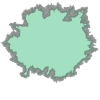

In [8]:
df_large_chickens.iloc[0]['Isochrone']

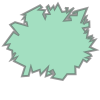

In [9]:
# shows the difference in resolution between the simplified and unsimplified isochrones
df_large_chickens.iloc[0]['Isochrone Cleaned']

In [10]:
# list the states that contain poultry plants
df_large_chickens.State.unique()

array(['AL', 'AR', 'CA', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MN', 'MO',
       'MS', 'NC', 'NE', 'OK', 'PA', 'SC', 'TN', 'TX', 'VA', 'WA', 'WV',
       'IA'], dtype=object)

In [11]:
# reassign the dataframe to df_map for processing later in the notebook
df_map = df_large_chickens

### Create Map

In [12]:
# center of the USA: 37.0902° N, 95.7129° W
USA_LAT = 37.0902
USA_LNG = -95.7129

In [13]:
# folium requires these "color mapping functions" to add colors to the map
empty_color = lambda x: {
    "fillColor": "00" # empty
}

one_plant_color = lambda x: {
    "fillColor": "#ED7117" # carrot
}

two_plant_color = lambda x: {
    "fillColor": "#ED7117" # carrot
}

three_plant_color = lambda x: {
    "fillColor": "#9F2B68" # amaranth
}

four_plant_color = lambda x: {
    "fillColor": "#90ee90" # light green
}

#### Add Plants to Map Layer and Extract Isochrones for Geospatial Processing

In [14]:
# add markers and isochrones to map, sort isochrones by parent company
isochrones = []
sep_isochrones = []
# create an empty dictionary to fill with unique parent companies 
dict = {}
# driving_distance_layer = folium.map.FeatureGroup(name="60 Mile Driving Distance")
plants_layer = folium.map.FeatureGroup(name="Large Poultry Plants")

for index, row in df_map.iterrows():
    lat = str(row['latitude'])
    lng = str(row['longitude'])

    # set up plant tooltip
    name = row['Establishment Name']
    corp = row['Parent Corporation']
    address = row['Full Address']

    # add plant marker to map
    tooltip = folium.map.Tooltip(f"{name}<br>{address}<br>Parent Corporation: {corp}")
    folium.Marker(location=[lat, lng],tooltip=tooltip).add_to(plants_layer)

    isochrone = row['Isochrone Cleaned']
    corp = row['Parent Corporation']

    # sorting by parent corp
    if (corp in dict):
        dict[corp].append(isochrone)
    else:
        dict[corp] = [isochrone]

    # Can add the isochrones to the map, too, but this gets pretty cluttered with the other geospatial data
    # add driving radius isochrone to map layer
    # geojson = folium.GeoJson(row['Isochrone Cleaned'], style_function=empty_color)
    # geojson.add_to(driving_distance_layer)

In [15]:
# union all isochrones with same parent corp together, make one list of the 21 merged isochrones
for key in dict:
    chrone = shapely.unary_union(dict[key])
    isochrones.append(chrone)

In [16]:
len(isochrones)

21

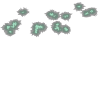

In [17]:
# example isochrone
isochrones[0]

In [18]:
#look at the unique parent corps in the DF
df_large_chickens['Parent Corporation'].value_counts().index.tolist()

['Tyson',
 'JBS',
 'Cargill',
 'Perdue',
 'Independent',
 'Peco Foods',
 'Koch Foods',
 "George's",
 'Foster Farms',
 'Mountaire',
 'House of Raeford',
 'Mar-Jac',
 'Amick',
 'Case Farms',
 'Sechler Family Foods, Inc.',
 'Fieldale Farms Corporation',
 'Simmons Foods',
 'Bachoco',
 'Costco',
 'Aterian Investment Partners',
 'Harim Group']

In [19]:
# create actual folium map object
m = folium.Map(location=[USA_LAT, USA_LNG],zoom_start=4)

#### Calculate Single-Plant Capture

In [20]:
# create single-plant capture area by removing one isochrone at a time and saving the area that is unique to that isochrone
single_plants_shapely = []

for index, poly in enumerate(isochrones):
    others = shapely.unary_union(isochrones[:index] + isochrones[index+1:])
    single_plant = shapely.difference(poly, others)
    single_plants_shapely.append(single_plant)

In [21]:
# create folium layer for single plant capture
# using the dictionary, add a tooltip that shows which parent corp owns each single capture area
parent_names = list(dict.keys())

for index, poly in enumerate(single_plants_shapely):
    corp = parent_names[index]
    title = "Only access to " + corp
    layer = folium.map.FeatureGroup(name=title)
    tooltip = folium.map.Tooltip(f"Parent Corporation: {corp}")
    folium.GeoJson(poly, tooltip=tooltip).add_to(layer)
    layer.add_to(m)

In [22]:
# calculate competitive area for filtering in the next stage
everything = shapely.unary_union(isochrones)
single_plant_combined = shapely.unary_union(single_plants_shapely)
competition_single_plant = shapely.difference(everything, single_plant_combined)

#### Calculate Two Plant Capture

In [23]:
# exclude any isochrones that are fully in single plant capture area
isochrones_shapely_two_plants = []
for isochrone in isochrones:
    if isochrone.intersection(competition_single_plant):
        isochrones_shapely_two_plants.append(isochrone)

In [24]:
len(isochrones_shapely_two_plants)

20

In [25]:
# logic here is similar to single plant capture with just a bit more complexity since we are now looking at two plant capture so we need to do a nested loop
two_plants_shapely = []
for i in range(len(isochrones_shapely_two_plants)):
    for j in range(i+1, len(isochrones_shapely_two_plants)):
        plant_1 = isochrones_shapely_two_plants[i]
        plant_2 = isochrones_shapely_two_plants[j]

        # check if there's an intersection between the areas
        if not plant_1.intersection(plant_2):
            continue
        else:
            two_plant_area = shapely.unary_union([plant_1,plant_2])

        # exclude first plant
        other_plants = isochrones_shapely_two_plants[:i]
        # exclude second plant
        other_plants += isochrones_shapely_two_plants[i+1:j]
        other_plants += isochrones_shapely_two_plants[j+1:]

        # find the area where there's only two plants
        others_combined = shapely.unary_union(other_plants)
        captured_area = shapely.difference(two_plant_area, others_combined) # returns the part of geometry a that does not intersect with geometry b
        # remove the area that is captured by only one of the plants
        captured_area = shapely.difference(captured_area, single_plant_combined)
        if captured_area:
            two_plants_shapely.append(captured_area)


In [26]:
len(two_plants_shapely)

74

In [27]:
two_plant_layer = folium.map.FeatureGroup(name="Access to 2 Parent Corporations")
two_plants_combined = shapely.unary_union(two_plants_shapely)
folium.GeoJson(two_plants_combined,style_function=two_plant_color).add_to(two_plant_layer)

In [28]:
# calculate competitive area for filtering in the next stage
competition_two_plant = shapely.difference(competition_single_plant, two_plants_combined)

#### Calculate Three Plant Competition Area

In [29]:
# exclude any plants that don't intersect with the competition area
isochrones_shapely_three_plants = []
for isochrone in isochrones:
    if isochrone.intersection(competition_two_plant):
        isochrones_shapely_three_plants.append(isochrone)

In [30]:
len(isochrones_shapely_three_plants)

20

In [31]:
# same idea as previous steps, now we just need to do this for three plants
three_plants_shapely = []
for i in range(len(isochrones_shapely_three_plants)):
    for j in range(i+1, len(isochrones_shapely_three_plants)):
        for k in range(j+1, len(isochrones_shapely_three_plants)):
            plant_1 = isochrones_shapely_three_plants[i]
            plant_2 = isochrones_shapely_three_plants[j]
            plant_3 = isochrones_shapely_three_plants[k]

            # check if there's an intersection between the areas
            if not plant_1.intersection(plant_2).intersection(plant_3):
                continue
            else:
                three_plant_area = shapely.unary_union([plant_1,plant_2,plant_3])

            # exclude first plant
            other_plants = isochrones_shapely_three_plants[:i]
            # exclude second plant
            other_plants += isochrones_shapely_three_plants[i+1:j]
            other_plants += isochrones_shapely_three_plants[j+1:k]
            # exclude third plant
            other_plants += isochrones_shapely_three_plants[k+1:]

            # find the area where there's only two plants
            others_combined = shapely.unary_union(other_plants)
            captured_area = shapely.difference(three_plant_area, others_combined) # returns the part of geometry a that does not intersect with geometry b
            # remove the area that is captured by only one of the plants
            captured_area = shapely.difference(captured_area, single_plant_combined)
            # remove the area that is captured by only two of the plants
            captured_area = shapely.difference(captured_area, two_plants_combined)
            if captured_area:
                three_plants_shapely.append(captured_area)


In [32]:
len(three_plants_shapely)

88

In [33]:
# create three plant layer
three_plant_layer = folium.map.FeatureGroup(name="Access to 3 Parent Corporations")
three_plants_combined = shapely.unary_union(three_plants_shapely)
folium.GeoJson(three_plants_combined,style_function=three_plant_color).add_to(three_plant_layer)

#### Calculate 4+ Plant Competition Area

In [34]:
# 4+ plants is everything else that is left over
four_plants_combined = shapely.difference(everything, single_plant_combined)
four_plants_combined = shapely.difference(four_plants_combined, two_plants_combined)
four_plants_combined = shapely.difference(four_plants_combined.buffer(0), three_plants_combined.buffer(0)) # add buffer(0) to handle floating point errors

In [35]:
# create folium layer
four_plant_layer = folium.map.FeatureGroup(name="Access to 4+ Parent Corporations")
folium.GeoJson(four_plants_combined,style_function=four_plant_color).add_to(four_plant_layer)

#### Display Map

In [36]:
# add each of our previously created layers to the folium map
plants_layer.add_to(m)
two_plant_layer.add_to(m)
three_plant_layer.add_to(m)
four_plant_layer.add_to(m)
folium.map.LayerControl().add_to(m) # you need to add layer control *last* or else nothing will show up on the map
m

##### Save Map

In [37]:
# don't need to do this unless you want to actually save the map
# export html of map
m.save("../html/poultry-map-smoothed.html")

In [38]:
one_df = gpd.GeoDataFrame({"Plant Access": [1] * len(single_plants_shapely), 
                           "Parent Corporation": list(dict.keys()), 
                           "Geometry": single_plants_shapely})
two_df = gpd.GeoDataFrame({"Plant Access": [2] * len(two_plants_shapely), 
                           "Parent Corporation": [None] * len(two_plants_shapely), 
                           "Geometry": two_plants_shapely})
three_df = gpd.GeoDataFrame({"Plant Access": [3] * len(three_plants_shapely), 
                            "Parent Corporation": [None] * len(three_plants_shapely), 
                            "Geometry": three_plants_shapely})
four_df = gpd.GeoDataFrame({"Plant Access": [4] * len([four_plants_combined]),
                            "Parent Corporation": [None] * len([four_plants_combined]),
                            "Geometry": [four_plants_combined]})

full_df = gpd.GeoDataFrame(pd.concat([one_df, two_df, three_df, four_df], ignore_index=True))
full_df = full_df.set_geometry('Geometry')
full_df.to_file("../isochrones_with_parent_corp.geojson", driver="GeoJSON")

### Include State Level Data

In [39]:
us_states = gpd.read_file("../../data/gz_2010_us_040_00_500k.json").set_crs(WGS84)

In [40]:
us_states.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ..."
1,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ..."
2,0400000US26,26,Michigan,,56538.901,"MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ..."
3,0400000US30,30,Montana,,145545.801,"POLYGON ((-104.05770 44.99743, -104.25015 44.9..."
4,0400000US32,32,Nevada,,109781.180,"POLYGON ((-114.05060 37.00040, -114.04999 36.9..."


In [41]:
us_states.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [42]:
print(us_states.iloc[0]['geometry'].centroid)

POINT (-69.22532171969658 45.36948088392073)


In [43]:
df_large_chickens.State.unique()

array(['AL', 'AR', 'CA', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MN', 'MO',
       'MS', 'NC', 'NE', 'OK', 'PA', 'SC', 'TN', 'TX', 'VA', 'WA', 'WV',
       'IA'], dtype=object)

In [44]:
abb2state = {
    'AL': "Alabama", 
    'AR': "Arkansas", 
    'CA': "California", 
    'DE': "Delaware", 
    'FL': "Florida", 
    'GA': "Georgia", 
    'KY': "Kentucky", 
    'LA': "Louisiana", 
    'MD': "Maryland", 
    'MN': "Minnesota", 
    'MO': "Missouri",
    'MS': "Mississippi", 
    'NC': "North Carolina", 
    'NE': "Nebraska", 
    'OK': "Oklahoma", 
    'PA': "Pennsylvania", 
    'SC': "South Carolina", 
    'TN': "Tennessee", 
    'TX': "Texas", 
    'VA': "Virginia", 
    'WA': "Washington", 
    'WV': "West Virginia",
    'IA': "Iowa"
}

In [45]:
# highlight function (change displayed on hover)
# again, Folium uses these kinda weird style functions that you pass when creating the layer
state_function = lambda x: {
  'color': 'red', # stroke becomes red
  'fillColor': '#00000000',
  # 'opacity' : 0.9,
  # 'weight': 4,
  'dashArray' : '3, 6' # transforms the solid stroke to a dashed stroke
}

In [46]:
mm = folium.Map(location=[USA_LAT, USA_LNG],zoom_start=4)

In [47]:
df_states = gpd.GeoDataFrame()

In [48]:
corp_dfs = []
for corp in df_large_chickens['Parent Corporation'].unique():
    df = df_large_chickens[df_large_chickens['Parent Corporation'] == corp]
    corp_dfs.append(df)

In [49]:
len(corp_dfs)

21

In [50]:
states = df_large_chickens.State.unique()

In [51]:
len(states)

23

In [52]:
corp_dfs[0].head()

,Unnamed: 0,EstNumber,EstID,Parent Corporation,Establishment Name,State,Size,Animals Processed,Processed\nVolume\nCategory,Slaughter\nVolume\nCategory,Full Address,latitude,longitude,Isochrone,Isochrone Cleaned
71,71,P1317 + V1317,4495,Cargill,Wayne Farms LLC,AL,Large,Chicken,5.0,5.0,"700 McDonald Avenue, Albertville, AL 35950",34.260726,-86.203222,"POLYGON ((-86.08922 34.95820, -86.09322 34.953...","POLYGON ((-86.08922 34.95820, -86.15222 34.854..."
72,72,P7485 + V7485,4518,Cargill,Wayne Farms LLC,AL,Large,Chicken,5.0,5.0,"1020 County Road 114, Jack, AL 36346",31.500628,-85.903438,"POLYGON ((-86.10144 32.28215, -86.10341 32.280...","POLYGON ((-86.10144 32.28215, -86.09208 32.217..."
73,73,P912,4493,Cargill,"Wayne Farms, LLC",AL,Large,Chicken,5.0,5.0,"444 Baskin Street South, Union Springs, AL 36089",32.139166,-85.721704,"POLYGON ((-85.77570 32.87582, -85.77767 32.859...","POLYGON ((-85.77570 32.87582, -85.85496 32.823..."
74,74,P7342 + V7342,4516,Cargill,Wayne Farms LLC,AL,Large,Chicken,5.0,5.0,"808 Ross Clark Circle NE, Dothan, AL 36303",31.225754,-85.362068,"POLYGON ((-85.11607 32.00221, -85.11784 31.995...","POLYGON ((-85.11607 32.00221, -85.14907 31.921..."
75,75,P1235,4509,Cargill,Wayne Farms LLC,AL,Large,Chicken,5.0,5.0,"254 Ipsco Road, Decatur, AL 35601",34.607601,-87.042595,"POLYGON ((-86.88059 35.31872, -86.88225 35.314...","POLYGON ((-86.88059 35.31872, -86.95860 35.212..."


In [53]:
corps_joined = []
for corp_df in corp_dfs:
    corp_geomtery = corp_df['Isochrone Cleaned'].unary_union
    corp_data = {
        "parent_corporation": corp_df.iloc[0]["Parent Corporation"],
        "geometry": corp_geomtery,
    }
    corps_joined.append(corp_data)

In [54]:
df_corps_joined = gpd.GeoDataFrame(corps_joined)

In [55]:
df_corps_joined.head()

,parent_corporation,geometry
0,Cargill,"MULTIPOLYGON (((-89.86862 30.79215, -89.94894 ..."
1,JBS,"MULTIPOLYGON (((-85.70757 31.93805, -85.63108 ..."
2,Koch Foods,"MULTIPOLYGON (((-86.56466 32.94030, -86.55835 ..."
3,Mar-Jac,"MULTIPOLYGON (((-89.18553 32.02956, -89.26576 ..."
4,Peco Foods,"MULTIPOLYGON (((-88.68868 32.27185, -88.60658 ..."


In [73]:
from pyproj import Geod

# now, we want to intersect the corporate geojsons with the state geojsons so we have a geojson for each valid corporation/state pairing
corp_state_geojsons = []
# create layers for each corporation in each state
for i, corp in df_corps_joined.iterrows():
    # create an intersection with each state's monopsony area
    for state in states:
        state_name = abb2state[state]
        state_layer = folium.map.FeatureGroup(name=state_name, show=False)
        state_geometry = us_states[us_states["NAME"] == state_name]['geometry'].to_crs(WGS84)
        state_center = state_geometry.to_crs(ALBERS_EQUAL_AREA).centroid.to_crs(WGS84)

        one_plant = shapely.intersection(single_plant_combined,state_geometry).set_crs(WGS84).iloc[0]
        one_plant_one_corp_one_state = shapely.intersection(one_plant,corp.geometry)

        if one_plant_one_corp_one_state:

            geod = Geod(ellps="WGS84")
            area = abs(geod.geometry_area_perimeter(one_plant_one_corp_one_state)[0]) * (0.000621371**2)

            one_plant_one_state_data = {
                "state": state_name,
                "geometry": one_plant_one_corp_one_state,
                "parent_corporation": corp.parent_corporation,
                "area": area,
                "corporate_access": 1
            }

            corp_state_geojsons.append(one_plant_one_state_data)

In [74]:
len(corp_state_geojsons)

118

In [75]:
for state in states:
    state_name = abb2state[state]
    state_layer = folium.map.FeatureGroup(name=state_name, show=False)
    state_geometry = us_states[us_states["NAME"] == state_name]['geometry'].to_crs(WGS84)
    state_center = state_geometry.to_crs(ALBERS_EQUAL_AREA).centroid.to_crs(WGS84)

    two_plants = shapely.intersection(two_plants_combined,state_geometry).set_crs(WGS84).iloc[0]
    three_plants = shapely.intersection(three_plants_combined,state_geometry).set_crs(WGS84).iloc[0]
    four_plants = shapely.intersection(four_plants_combined,state_geometry).set_crs(WGS84).iloc[0]
        
    if two_plants:
        geod = Geod(ellps="WGS84")
        two_area = abs(geod.geometry_area_perimeter(two_plants)[0]) * (0.000621371**2)

        two_plants_one_state_data = {
            "state": state_name,
            "geometry": two_plants,
            "parent_corporation": np.nan,
            "area": two_area,
            "corporate_access": 2
        }

        corp_state_geojsons.append(two_plants_one_state_data)

    if three_plants:
        geod = Geod(ellps="WGS84")
        three_area = abs(geod.geometry_area_perimeter(three_plants)[0]) * (0.000621371**2)

        three_plants_one_state_data = {
            "state": state_name,
            "geometry": three_plants,
            "parent_corporation": np.nan,
            "area": three_area,
            "corporate_access": 3
        }

        corp_state_geojsons.append(three_plants_one_state_data)

    if four_plants:
        geod = Geod(ellps="WGS84") 
        four_area = abs(geod.geometry_area_perimeter(four_plants)[0]) * (0.000621371**2)

        four_plants_one_state_data = {
            "state": state_name,
            "geometry": four_plants,
            "parent_corporation": np.nan,
            "area": four_area,
            "corporate_access": 4
        }

        corp_state_geojsons.append(four_plants_one_state_data)

In [76]:
len(abb2state)

23

In [77]:
len(corp_state_geojsons)

162

In [78]:
df_corp_state = gpd.GeoDataFrame(corp_state_geojsons)

In [79]:
df_corp_state = df_corp_state.sort_values(by='state')
df_corp_state

,state,geometry,parent_corporation,area,corporate_access
0,Alabama,GEOMETRYCOLLECTION (POLYGON ((-86.67324 31.387...,Cargill,838.729911,1
41,Alabama,GEOMETRYCOLLECTION (POLYGON ((-86.71277 33.354...,Tyson,98.333396,1
37,Alabama,GEOMETRYCOLLECTION (POLYGON ((-88.43374 32.209...,Peco Foods,4337.036260,1
33,Alabama,GEOMETRYCOLLECTION (POLYGON ((-88.41887 31.060...,Mar-Jac,155.014570,1
29,Alabama,GEOMETRYCOLLECTION (POLYGON ((-86.82914 31.674...,Koch Foods,4570.957177,1
...,...,...,...,...,...
158,Virginia,"MULTIPOLYGON (((-81.46902 36.63375, -81.45701 ...",NaN,4201.417277,2
71,Washington,"MULTIPOLYGON (((-122.43625 46.49486, -122.3880...",Foster Farms,2918.531213,1
28,West Virginia,GEOMETRYCOLLECTION (POLYGON ((-79.26832 38.438...,JBS,2024.600400,1
64,West Virginia,GEOMETRYCOLLECTION (POLYGON ((-79.35780 38.496...,George's,222.758212,1


In [80]:
# Export corporate/state geojsons to file
df_corp_state.to_file("../../data/all_states_with_parent_corp_by_corp.geojson", driver="GeoJSON")

In [81]:
df_corp_state.loc[df_corp_state.state == 'Nebraska']

,state,geometry,parent_corporation,area,corporate_access
113,Nebraska,"POLYGON ((-96.04093 40.97102, -96.01681 40.867...",Costco,5570.369039,1
